# Modeling ESG Scores With Non-ESG Metrics

The idea for this study came from reading about the increasingly common practice of greenwashing, where companies exaggerate the good they’re doing for the world via their ESG risk — a metric for a company's exposure to and management of environmental, social and corporate governance risks — disclosures to entice investors, hoodwink customers and generally improve their financial performance. This project aims to shed light on what an investor or consumer is implicitly taking into account when they judge a company by its ESG score. More specifically, it will look at a) what factors correlate to higher third-party ESG scores. It turns out that we can model the variation in ESG score for multiple firms' ESG ratings pretty well looking exclusively at non-ESG company information, such as company size, various financial data, industry and stock price volatility. 


## About the data

### A) Company (financial) information

**Financial data** — quarterly (10Q) or annual (10K) reports that public companies are required to file to the U.S. Securities and Exchange Commission (SEC) — for this project is taken from a Kaggle dataset download[^1]. SEC filing data is notoriously difficult to parse since the XBRL formatting of its filings is clunky and hard to navigate, and 10-K reports are long and often larger than 50 MB per file. This dataset extracted key financial information from company 10-Q and 10-K filings of public companies and merged it with stock price history data from Yahoo Finance. The financial information comes from the SEC's bulk data downloads (company facts and submission history) and includes information about assets, debt, taxes and other data points in units of either dollars or stock shares that could give indications of a company's financial health/profile. The Yahoo Finance data is represented in price variance columns which are changes in price over 5, 10, 20, 30 and 60 day periods calculated from the day the form was filed. The data is in 4,624 thousand folders, one for each company. 

Additionally, I obtained:
* **Sector data** — a descriptor like "Banks," "Software," or "Chemicals" — by web scraping Yahoo Finance and downloading data from leading financial information services provider S&P Market Intelligence's Trucost Revenue Sector.
* **Number of employees** and other basic company information from by web scraping Yahoo Finance. 

[^1]: chartma. (2022). SEC Company Facts - All 10-Q & 10-K financial data [Data set](https://www.kaggle.com/datasets/chad116/sec-company-facts-all-10q-10k-financial-data/discussion). Kaggle. https://doi.org/10.34740/KAGGLE/DS/2292262

### B) ESG data

There are several organizations known for their ESG ratings, including MSCI ([Morgan Stanley Capital International](https://www.msci.com/documents/1296102/21901542/ESG-Ratings-Methodology-Exec-Summary.pdf)), [Sustainalytics](https://www.sustainalytics.com/esg-ratings), [Refinitiv](https://www.refinitiv.com/en/sustainable-finance/esg-scores), S&P Global and others. 

* **Sustainalytics**: Getting bulk data for all for all of these ratings is difficult and expensive, but Yahoo Finance — which is a publicly scrapable website — pulls sustainability data from Sustainalytics, financial firm Morningstar's ESG reporting branch. Thus, this project uses a dataset of ESG data from Sustainalytics, numbers that quantify the degree to which ESG issues put a company's business value at risk. The measures combine "exposure," which includes types of risks a particular company faces within its business model and "management," which deals with how the company addresses those risks. It defines its overall score as the amount of risk a company has and does not manage, segmenting those two components into a few dozen subcategories that include bribery, resource use, biodiversity, carbon emissions, social impact of products, human rights and categories. The Sustainalytics data this report uses has two parts: The first is scraped from Yahoo Finance and includes a total numeric ESG score; ESG score as a percentile; the E, S and G component scores; and a "controversy" rating based on incidents found in the news. However, Yahoo Finance does not have access to all of Sustainalytics' data (notably for many pharmaceutical companies), so I manually augmented that dataset by searching [Sustainalytics' engine](https://www.sustainalytics.com/esg-rating/) by company ticker — which contains only total ESG score. 

* **Refinitiv**: For a point of comparison, because of access to UPenn Wharton's Research Data Services(WRDS) through Yale, I submitted a query for a dataset that has ratings from Refinitiv's ESG scores as well, even though it is an outdated formula for scores (last updated in 2020, since WRDS does not have access to Refinitiv's most current methodology). Refinitiv's metrics are similar to Sustainalytics in most ways, but one difference is that it explicitly claims to adjust for industry materiality and company size biases. Refinitiv's ESG metrics also explicitly segment into subcategories — 186 of them, which include water/energy use, responsible marketing, human rights, data privacy, compensation and others.

# I. Getting and preparing the data

## A. Company 10-K (financial) information dataset
### Accessing and saving the data

The Kaggle financial dataset has a different CSV file for each dataset, which is difficult to work with. First, I'm creating a list of csv filenames so I can read them into this notebook and eventually merge them into one dataset. There are 4,624 files — supposedly one for each publicly listed company in the U.S. Although it is not clear how many public companies exist at the moment, a [McKinsey report](https://www.mckinsey.com/capabilities/strategy-and-corporate-finance/our-insights/reports-of-corporates-demise-have-been-greatly-exaggerated) said there were approximately 4,000 public companies in 2020, and a [Statista report](https://www.statista.com/statistics/1277216/nyse-nasdaq-comparison-number-listed-companies/) reported 4,891 public companies listed on the NYSE and NASDAQ exchanges. Thus, 4,624 is a probably number for the total number of public companies, since the number fluctuates due to company entrances, exits, mergers and acquisitions.

In [401]:
import pandas as pd # HIDE THIS LATER
import numpy as np
import json
import time
import os
import collections
from dask import dataframe as df1
import matplotlib.pyplot as plt
import math
import re
import sys
import sklearn
from sklearn.linear_model import LinearRegression
# !pip install statsmodels
import statsmodels.api as sm
np.set_printoptions(threshold=sys.maxsize)
# !pip install dask
# !pip install plotnine
# !pip install seaborn
import seaborn as sns

To start, we'll look at one of these data files to see what is inside. Here is one for the tech company Sanmina Corporation (ticker SANM). Each of these files has one row per document filed (10-Ks are filed yearly, while 10-Qs are filed quarterly) dating from the company's IPO date, the date at which it needed to start filing to the SEC. 

This file in particular has 51 rows, corresponding to 51 files and 429 columns, which we will explore in more detail shortly.

In [238]:
one_file = pd.read_csv("/Users/phoebeliu/Downloads/SEC_data_kaggle/sec_data_made_useable_w_pricevar/sec_data_made_useable_w_pricevar/CIK0000897723_SANM.csv")
np.shape(one_file)

(51, 429)

In [239]:
one_file.head(5)

,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,UnrecognizedTaxBenefitsResultingInNetOperatingLossCarryforward,UnrecognizedTaxBenefitsThatWouldImpactEffectiveTaxRate,ValuationAllowanceDeferredTaxAssetChangeInAmount,ValuationAllowancesAndReservesBalance,ValuationAllowancesAndReservesChargedToCostAndExpense,ValuationAllowancesAndReservesDeductions,WeightedAverageNumberDilutedSharesOutstandingAdjustment,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,GainLossOnDispositionOfAssets1
0,2008-09-27,2008-11-24,10-K,Sanmina Corporation,SANM,CIK0000897723,USD,-0.020833,0.041667,0.041667,...,NaN,NaN,NaN,13422000.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-10-03,2009-12-01,10-K,Sanmina Corporation,SANM,CIK0000897723,USD,0.171393,0.186190,0.398274,...,NaN,NaN,NaN,16752000.0,3571000.0,-241000.0,NaN,82528000.0,82528000.0,NaN
2,2010-01-02,2010-02-05,10-Q,Sanmina Corporation,SANM,CIK0000897723,USD,0.117231,0.291109,0.376082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80575000.0,78615000.0,NaN
3,2010-04-03,2010-04-30,10-Q,Sanmina Corporation,SANM,CIK0000897723,USD,-0.097246,-0.048342,-0.109050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82782000.0,79001000.0,NaN
4,2010-07-03,2010-08-05,10-Q,Sanmina Corporation,SANM,CIK0000897723,USD,-0.128878,-0.149562,-0.229912,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83693000.0,79544000.0,NaN


In the Sanmina Corp. example, there are 51 files ranging from 2008 to 2022, with 37 10-Qs and 14 10-Ks. Other files have similar ranges, with approximately three 10-Qs for every 10-K from either a) when the SEC first started collecting and storing this data publicly and b) when the company in question went public (since private companies don't have to file with the SEC).

In [244]:
print("Date range: {} to {}".format(one_file["filed"][0], one_file["filed"][len(one_file["filed"])-1]))
print("File counts:")
print(one_file["form"].value_counts())

Date range: 2008-11-24 to 2022-02-02
File counts:
10-Q    37
10-K    14
Name: form, dtype: int64


We can also take a look at some of the columns that exist in this data to gain a better understanding of it. There's a lot of financial jargon in the the following list, but a few categories of columns that jump out to me are:
* **AccountsPayableCurrent** and **AccountsReceivableCurrent**, which can be a reflection of financial health in that accounts payable indicates how much a company owes other people, and accounts receivable indicates how much other people owe the company
* **Assets**, which can be current or non-current, with current assets being things like stock, other cash equivalents and inventory
* **EffectiveIncomeTax** and several columns related to taxes and tax benefits can give an indication of company size and income, since the effective income tax rate is calculated by dividing total tax expenses by a company's pre-tax earnings
* **Stock** shares issued, earnings per share and other stock-related columns can give an indication of a company's market value — including the **PriceVariance** column from Yahoo Finance that deals with stock price volatility, which is relevant because some investors gravitate towards stocks with high price volatility for their portfolios.
* One miscellaneous column that stood out to me as the **Goodwill** column, since it represents intangible factors like brand reputation/value, how loyal a customer base is, the company's employee relations or any proprietary company. Goodwill is mainly used in the context of a company's price when another company wants to acquire it, but the factors in it seem like they could be in some ways correlated to ESG metrics (especially the S and G factors)


In [518]:
list(one_file.columns)[:20]

['end',
 'filed',
 'form',
 'Name',
 'Ticker',
 'CIK',
 'Currency',
 'PriceVar5',
 'PriceVar10',
 'PriceVar20',
 'PriceVar30',
 'PriceVar60',
 'AccountsAndOtherReceivablesNetCurrent',
 'AccountsPayableCurrent',
 'AccountsReceivableNetCurrent',
 'AccrualForEnvironmentalLossContingenciesIncreaseDecreaseForRevisionInEstimates',
 'AccruedLiabilitiesFairValueDisclosure',
 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment',
 'AccumulatedOtherComprehensiveIncomeLossCumulativeChangesInNetGainLossFromCashFlowHedgesEffectNetOfTax',
 'AccumulatedOtherComprehensiveIncomeLossDefinedBenefitPensionAndOtherPostretirementPlansNetOfTax']

I then concatenated all 4,624 files into one file so I could parse it more easily:

In [12]:
# I concatenated the files and saved it to my disk/uploaded to the project GitHub
# DO NOT RUN THIS CELL — unless you want to get the files yourself — it will take forever

# os.chdir("/Users/phoebeliu/Downloads/SEC_data_kaggle/sec_data_made_useable_w_pricevar/sec_data_made_useable_w_pricevar")
# csv_files = os.listdir()
# df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)
# np.shape(df)

This dataset is of dimension 170497 x 11690 — one row for each filing (10-K or 10-Q a company made) and one column for each piece of "financial data." There's an unreasonably high number of columns because the names of certain financial markers changed over the years and depending on the type of company and type of form filed.

The next cell saves the file to my local drive so I can access it more quickly in the future.

In [ ]:
df.to_csv("/Users/phoebeliu/Downloads/SEC_Kaggle_Big_Test2.csv") # changed the name so I don't accidentally overwrite the one that exists

Now that I have the data saved on my computer, I can get it by reading it into the notebook. Because it's a big (2GB) file, reading it normally took too long (many hours). I'm using dask to speed up the process by splitting up the data into multiple dataframes so the reading can happen on multiple data "slices" in parallel and thus exponentially faster. The issue with dask is that there's a lot of slicing etc. going on, so it is extremely computationally expensive/takes a long time to index — so once we filter out some of this data, we will convert it back to a normal pandas dataframe.

In [250]:
s_time_dask = time.time()
dask_all = df1.read_csv('/Users/phoebeliu/Downloads/SEC_Kaggle_Big_Test.csv', sample=1000000)
e_time_dask = time.time()
print("Read with dask: ", (e_time_dask-s_time_dask), "seconds")
dask_all.head(10)

Read with dask:  1.6129889488220215 seconds


,Unnamed: 0,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,...,ContractsInForceSubjectToParticipationThroughReinsuranceValue,IncomeTaxExpenseBenefitContinuingOperationsAdjustmentOfDeferredTaxAssetLiability.1,OtherComprehensiveIncomeLossFinancialLiabilityFairValueOptionBeforeTaxAfterReclassificationAdjustmentAttributableToParent,IncomeTaxHolidayIncomeTaxBenefitsPerShare.1,RetrospectiveEffectOfChangeInAccountingPrincipleTabularPresentationByFinancialStatementLineItemAmountOfApplicationAdjustment,AssumptionForFairValueOnSecuritizationDateOfInterestsContinuedToBeHeldByTransferorServicingAssetsOrLiabilitiesPrepaymentSpeed,EffectOfChangeInCashFlowProjectionEstimate,EntertainmentLicenseAgreementForProgramMaterialCapitalizedCost,FilmMonetizedOnItsOwnAndFilmMonetizedInFilmGroupAmortizationExpense,ProceedsFromDivestitureOfInterestInJointVenture.1
0,0,2011-04-30,2011-06-16,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2011-07-31,2011-11-10,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2011-10-31,2011-12-20,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,-0.048387,-0.048387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2012-01-31,2012-03-21,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.704546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2012-04-30,2012-06-14,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,-0.180328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2012-07-31,2012-11-13,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,-0.166667,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2012-10-31,2012-12-17,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2013-01-31,2013-03-15,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2013-04-30,2013-06-14,10-Q,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2013-07-31,2013-10-29,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filtering the data

This is a big dataset. It has too many columns, and most of them are mostly empty (depending on the form and year and even company, the columns are named different things). The goal of this section is to whittle the data into a more manageable size.

Since Sustainalytics' ESG ratings are updated annually, let's look exclusively at 10-K (annual report) data. 

In [252]:
dask_10ks = dask_all[dask_all["form"]=="10-K"]

In [ ]:
# Saving the file to my disk so I can load it again later
# dask_10ks.to_csv("/Users/phoebeliu/Downloads/SEC_Kaggle_10Ks.csv") -- it's saved already so I can deal with this later 

In [253]:
dask_10ks.head(5) # checking that they are all 10-Ks

,Unnamed: 0,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,...,ContractsInForceSubjectToParticipationThroughReinsuranceValue,IncomeTaxExpenseBenefitContinuingOperationsAdjustmentOfDeferredTaxAssetLiability.1,OtherComprehensiveIncomeLossFinancialLiabilityFairValueOptionBeforeTaxAfterReclassificationAdjustmentAttributableToParent,IncomeTaxHolidayIncomeTaxBenefitsPerShare.1,RetrospectiveEffectOfChangeInAccountingPrincipleTabularPresentationByFinancialStatementLineItemAmountOfApplicationAdjustment,AssumptionForFairValueOnSecuritizationDateOfInterestsContinuedToBeHeldByTransferorServicingAssetsOrLiabilitiesPrepaymentSpeed,EffectOfChangeInCashFlowProjectionEstimate,EntertainmentLicenseAgreementForProgramMaterialCapitalizedCost,FilmMonetizedOnItsOwnAndFilmMonetizedInFilmGroupAmortizationExpense,ProceedsFromDivestitureOfInterestInJointVenture.1
1,1,2011-07-31,2011-11-10,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2012-07-31,2012-11-13,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,-0.166667,-0.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2013-07-31,2013-10-29,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,2014-07-31,2014-11-12,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000049,-0.073126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,17,2015-07-31,2015-11-20,10-K,"POINT OF CARE NANO-TECHNOLOGY, INC.",PCNT,CIK0001504239,USD,0.000000,-0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, since we are only using the most recent year of Sustainalytics ratings (historical data is not currently publicly accessible), we will get 10-Ks from just this past year (one per company). First, let's get everything in 2021 and after:

In [254]:
recent_10ks = dask_10ks[dask_10ks["filed"] > "2020-12-31"]

In [17]:
recent_10ks.head(5) # showing that recent_10ks does what it is supposed to 

,Unnamed: 0,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,...,ContractsInForceSubjectToParticipationThroughReinsuranceValue,IncomeTaxExpenseBenefitContinuingOperationsAdjustmentOfDeferredTaxAssetLiability.1,OtherComprehensiveIncomeLossFinancialLiabilityFairValueOptionBeforeTaxAfterReclassificationAdjustmentAttributableToParent,IncomeTaxHolidayIncomeTaxBenefitsPerShare.1,RetrospectiveEffectOfChangeInAccountingPrincipleTabularPresentationByFinancialStatementLineItemAmountOfApplicationAdjustment,AssumptionForFairValueOnSecuritizationDateOfInterestsContinuedToBeHeldByTransferorServicingAssetsOrLiabilitiesPrepaymentSpeed,EffectOfChangeInCashFlowProjectionEstimate,EntertainmentLicenseAgreementForProgramMaterialCapitalizedCost,FilmMonetizedOnItsOwnAndFilmMonetizedInFilmGroupAmortizationExpense,ProceedsFromDivestitureOfInterestInJointVenture.1
63,63,2020-12-31,2021-04-13,10-K,"MINIM, INC.",MINM,CIK0001467761,USD,-0.131098,-0.085366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,120,2020-12-31,2021-02-26,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,-0.044723,-0.019422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,124,2021-12-31,2022-02-25,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,0.048832,-0.018476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,130,2020-12-31,2021-02-26,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.030712,0.124345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,134,2021-12-31,2022-02-28,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.000000,0.014622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, let's organize this to make sure there's only one report per company, and that it is the most recent one. 

In [255]:
tickerlist = dask_10ks["Ticker"].compute()
nonduplicates = list(set(tickerlist))

### Trying to sort out discrepancies in number of public companies/filings

Getting a list of all the company tickers (what they're listed as on an exchange) returned a list of length 4588 — fewer than the 4624 files. This can be explained by a) some companies merging into one ticker, old companies that no longer exist, etc.

In [256]:
len(nonduplicates)

4588

In [263]:
ciks = dask_10ks["CIK"]
nondup_ciks = list(set(ciks))
nondup_ciks[:10]

['CIK0001371489',
 'CIK0000090498',
 'CIK0001784254',
 'CIK0001326110',
 'CIK0001400732',
 'CIK0001611547',
 'CIK0001378125',
 'CIK0001419051',
 'CIK0000088121',
 'CIK0001745078']

Additionally, as a check, I compiled a list of CIKs (central identification keys — a company identifier which, like tickers, is unique) of all companies that submitted 10-Ks to the SEC within the last year. That list has 7868 items, which is a lot more than both of these ticker lists. That discrepancy can be explained by the fact that many of those 7868 companies are not "real companies" and are rather trusts, SPACs and other acquisition-focused companies, holding companies such as "Strats(SM) Trust for Dominion Resources," "CNH Equipment Trust 2021-B" and "Securities, Series 2005-6." Most of these are "smaller reporting companies" — which means that by the SEC's standards, those companies do not have to report ESG risks. (The SEC does not include those companies in its own bulk data downloads from its [company facts API](https://www.sec.gov/edgar/sec-api-documentation), so we can ignore them for the purposes of this project.

In [258]:
all_ciks = pd.read_csv("/Users/phoebeliu/Downloads/All_Tickers_Researched.csv") 
# This file is the download of tickers and CIKs from all companies that submitted a 10-K to the SEC 
# within the last year, which is also available in the GitHub repo

In [269]:
nondup_ciks = [re.sub("CIK", "", elem) for elem in nondup_ciks]
nondup_ciks = [int(x) for x in nondup_ciks]

[1371489, 90498, 1784254, 1326110, 1400732]


Here, we can see the CIKs few of the 3368 companies that filed 10-Ks with the SEC but are not included in the Kaggle dataset of financial data we are using (examples: Spire Alabama, Hanover House, Kingsway Financial Services). It seems that the Kaggle dataset is not perfect/all-encompassing — since these companyies do have pretty robust "company information" files from the [SEC's Company Facts API](https://www.sec.gov/edgar/sec-api-documentation). There is definitely more exploring to be done here — but I did not have the time/knowledge to parse the XBRL files myself and see if I could get more data. Additionally, around 500 of these 3368 missing files came from a lack of Yahoo Finance Price Variance data.

In [286]:
# gets symmetric difference, wich is 3671 (3368 + 303)
# set_dif = set(all_ciks["CIK"]).symmetric_difference(set(nondup_ciks)) 
# difference = list(set_dif)
# print(len(difference))

left_diff = set(all_ciks["CIK"]).difference(nondup_ciks)
print(len(left_diff))
print(difference[500:510])

3368
[1069680, 1070050, 1071272, 1072627, 1072842, 1073349, 1074871, 1075415, 1075857, 1077428]


Now, if we go the other way around, there are also some companies included in the Kaggle dataset that did not file with the SEC in the last year — 303 companies.

In [295]:
right_diff = len(set(nondup_ciks).difference(all_ciks))
print(right_diff)
list(set(nondup_ciks).difference(all_ciks))[:10]

4588


[851968,
 917520,
 704532,
 1441816,
 1032220,
 98338,
 1490978,
 1163302,
 1622057,
 1425450]

I did not go through the list exhaustively, but most of the 303 are companies that exited in some way (no longer public or went bankrupt or got acquired). The data is still good, though, so we will keep them in our dataset.

### Making the financial data more manageable (cutting down number of columns)

11,000 columns is too many to model anything that is easily interpretable. First, let's drop all the columns that have no entries (probably old or 10-Q specific things). Our goal is to get this data into a manageable size so we can convert it back to a non-dask dataframe to analyze it more conveniently. This gets us to 7408, which is ... still a lot.

In [58]:
recent_10ks_withoutna = recent_10ks.loc[:, ~recent_10ks.isna().all().compute()] # no need to run this cell

KeyboardInterrupt: 

Now, let's set a threshold to cut down the number of columns even more. I'm setting an arbitrary threshold of 3000, or about half the companies (since there are 4588 companies represented and each one should have 1-2 10-K reports filed since 2021 began). So these columns would still be majority null/NA. This results in 81 columns, which is much more manageable.

In [ ]:
THRESHOLD = 3000
recent_10ks_fewer_na = recent_10ks_withoutna.loc[:, recent_10ks_withoutna.isna().sum().compute() < THRESHOLD] 

In [ ]:
recent_10ks_fewer_na.head(5)

Now, we can convert this back to a regular dataframe. We will use this dataset later to merge with the ESG rating data.

In [ ]:
final_10ks = recent_10ks_fewer_na.compute()

In [ ]:
# Saving this dataset to my local drive
# final_10ks.to_csv("/Users/phoebeliu/Downloads/Final_10k_document.csv") 

Here is the 10-K dataset we're working with in pandas dataframe form. Notice that the columns still have columns with significan numbers of NAs in them (because this varies company to company as well) – this is something we will need to work around.

In [2]:
final_10k_set = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/Final_10k_document.csv")
final_10k_set = final_10k_set.iloc[:,2:]
final_10k_set.iloc[:10]

,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect,EffectiveIncomeTaxRateContinuingOperations,LesseeOperatingLeaseLiabilityPaymentsDueAfterYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities
0,2020-12-31,2021-04-13,10-K,"MINIM, INC.",MINM,CIK0001467761,USD,-0.131098,-0.085366,-0.094512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-31,2021-02-26,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,-0.044723,-0.019422,-0.016289,...,21591000.0,20907000.0,127427000.0,0.109,15289000.0,5002000.0,8279000.0,10185000.0,18443000.0,NaN
2,2021-12-31,2022-02-25,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,0.048832,-0.018476,-0.017034,...,21781000.0,21206000.0,156730000.0,0.163,10577000.0,4842000.0,5129000.0,11256000.0,21537000.0,NaN
3,2020-12-31,2021-02-26,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.030712,0.124345,0.053184,...,52548547.0,52070624.0,221490000.0,NaN,NaN,NaN,NaN,NaN,NaN,15222000.0
4,2021-12-31,2022-02-28,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.000000,0.014622,0.032422,...,52030582.0,51291428.0,73917000.0,NaN,NaN,NaN,NaN,NaN,NaN,11555000.0
5,2020-12-31,2021-02-25,10-K,TIMKENSTEEL CORPORATION,TMST,CIK0001598428,USD,0.201560,0.439532,0.248375,...,45000000.0,45000000.0,75700000.0,-0.020,NaN,NaN,2700000.0,8800000.0,0.0,120600000.0
6,2021-12-31,2022-02-24,10-K,TIMKENSTEEL CORPORATION,TMST,CIK0001598428,USD,0.272485,0.235177,0.548967,...,55000000.0,45900000.0,156800000.0,0.032,NaN,NaN,1100000.0,8200000.0,0.0,100500000.0
7,2020-12-31,2021-03-11,10-K,"FUNKO, INC.",FNKO,CIK0001704711,USD,0.189172,0.255055,0.563601,...,35770013.0,35270795.0,27026000.0,0.172,27614000.0,10028000.0,11279000.0,11600000.0,490000.0,1339000.0
8,2021-12-31,2022-03-03,10-K,"FUNKO, INC.",FNKO,CIK0001704711,USD,-0.026404,-0.019663,-0.038764,...,40610618.0,38392390.0,31302000.0,0.201,20489000.0,9303000.0,10504000.0,14400000.0,0.0,1044000.0
9,2020-12-31,2021-03-11,10-K,"electroCore, Inc.",ECOR,CIK0001560258,USD,0.018692,-0.028037,-0.037383,...,NaN,NaN,-9321854.0,0.047,526560.0,149700.0,146044.0,NaN,NaN,461485.0


Notice that there are still multiple entries per company. Let's make sure that is not the case. We end this part with a dataset containing 4349 rows and 80 columns.

In [3]:
final_10k_set = final_10k_set.drop_duplicates(subset='CIK', keep="last")
print(np.shape(final_10k_set))
final_10k_set[:3]

(4349, 80)


,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect,EffectiveIncomeTaxRateContinuingOperations,LesseeOperatingLeaseLiabilityPaymentsDueAfterYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities
0,2020-12-31,2021-04-13,10-K,"MINIM, INC.",MINM,CIK0001467761,USD,-0.131098,-0.085366,-0.094512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-12-31,2022-02-25,10-K,ICU MEDICAL INC/DE,ICUI,CIK0000883984,USD,0.048832,-0.018476,-0.017034,...,21781000.0,21206000.0,156730000.0,0.163,10577000.0,4842000.0,5129000.0,11256000.0,21537000.0,NaN
4,2021-12-31,2022-02-28,10-K,"CROSSFIRST BANKSHARES, INC.",CFB,CIK0001458412,USD,0.000000,0.014622,0.032422,...,52030582.0,51291428.0,73917000.0,NaN,NaN,NaN,NaN,NaN,NaN,11555000.0


## B. Getting ESG scores data and merging it with original financial data

To get a dataset of ESG metrics from Yahoo Finance, I built a list of URLs to Yahoo Finance's "Sustainability" tab for each company, since their URLs all followed the same pattern. Example: [https://finance.yahoo.com/quote/AAPL/sustainability?p=AAPL](https://finance.yahoo.com/quote/AAPL/sustainability?p=AAPL). 

To scrape the site itself, I needed to access the HTML and save it to my computer (so I can recompute it quickly). I tried several approaches (including but not limited to creating a collection runner in the API platform Postman, which ended up crashing my computer several times) but landed on a function through python's multiprocessing library that allowed me to save the 4588 HTML files to my disk.

Then, I used BeautifulSoup to extract the relevant elements (code is in a separate notebook also in the GitHub repository). Finally, I saved the file to my computer. 

Here are the first few lines, with a ticker, total ESG score, percentile, component scores and a rating for controversy based on media/news attention: 

In [4]:
scores_yahoo = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/yahoo_sustainalytics_score.csv")
scores_yahoo[:5]

,ticker,total ESG score,percentile,e_score,s_score,g_score,controversy
0,CAH,12,5th percentile,2.0,6.0,5.0,3.0
1,PGR,21,28th percentile,2.0,8.0,11.0,1.0
2,MDLZ,24,39th percentile,9.0,9.0,5.0,3.0
3,DXCM,24,39th percentile,5.0,10.0,8.0,0.0
4,HPQ,11,3rd percentile,0.0,5.0,6.0,2.0


Since the tickers I fed into my scraper are tickers from the SEC Kaggle dataset, there isn't anything in here that does not correspond to a set of SEC filings. 

However, notice that there are only 506 rows:

In [5]:
np.shape(scores_yahoo)

(506, 7)

Why are many of these companies missing SEC data when Sustainalytics claims to have rankings that cover all the main stock indices? I went on Sustainalytics' ESG website and then found that many companies that do not have sustainability data listed on Yahoo Finance. I couldn't figure out why this was, but it tended to be majority pharmaceutical companies and banks/bancorps (companies that control banks but do not actually do banking).

## Merging with the Kaggle financial information dataset

In [351]:
scores_yahoo = scores_yahoo.rename(columns={"ticker": "Ticker"})
merged_kaggle_yahoo = pd.merge(final_10k_set, scores_yahoo, on='Ticker')
print(np.shape(merged_kaggle_yahoo))
merged_kaggle_yahoo[:5]

(506, 86)


,end,filed,form,Name,Ticker,CIK,Currency,PriceVar5,PriceVar10,PriceVar20,...,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities,total ESG score,percentile,e_score,s_score,g_score,controversy
0,2021-12-31,2022-02-22,10-K,SEI INVESTMENTS COMPANY,SEIC,CIK0000350894,USD,0.003254,-0.043501,0.030142,...,5483000.0,10132000.0,1.488600e+07,9.536200e+07,19,22nd percentile,1.0,8.0,10.0,1.0
1,2021-12-31,2022-02-08,10-K,INCYTE CORPORATION,INCY,CIK0000879169,USD,-0.057799,-0.027116,0.015413,...,1418000.0,14300000.0,6.235900e+07,4.037800e+07,24,39th percentile,1.0,16.0,7.0,1.0
2,2021-12-31,2022-02-16,10-K,Amgen Inc.,AMGN,CIK0000318154,USD,-0.007455,0.026633,0.040465,...,49000000.0,190000000.0,3.546000e+09,1.449000e+09,22,32nd percentile,1.0,13.0,8.0,3.0
3,2021-12-31,2022-02-22,10-K,Centene Corporation,CNC,CIK0001071739,USD,0.015861,0.026558,0.066642,...,341000000.0,385000000.0,3.550000e+08,2.792000e+09,21,28th percentile,0.0,13.0,7.0,2.0
4,2021-12-31,2022-02-09,10-K,AMPHENOL CORPORATION,APH,CIK0000820313,USD,-0.039880,-0.079010,-0.063508,...,28800000.0,103200000.0,1.477000e+08,5.857000e+08,22,31st percentile,8.0,5.0,8.0,2.0


This is a small dataset, but let's explore it first and see what insights we can gain for now.

# II. Exploring the data

## A. Exploring distribution of ESG scores and components (response variable)
 
First, we will look at distribution of various ESG metrics within this small dataset. 

### Total ESG score (Yahoo finance-scraped Sustainalytics data)

The histogram is almost bimodal if we increase the number of bins, but it should be fine for our purposes. It's also a bit right-skewed, which we could transform with a sqrt transformation, but the decreased interpetability of our dataset isn't worth the more normal response variable distribution.

Text(0.5, 1.0, 'Untransformed ESG score histogram')

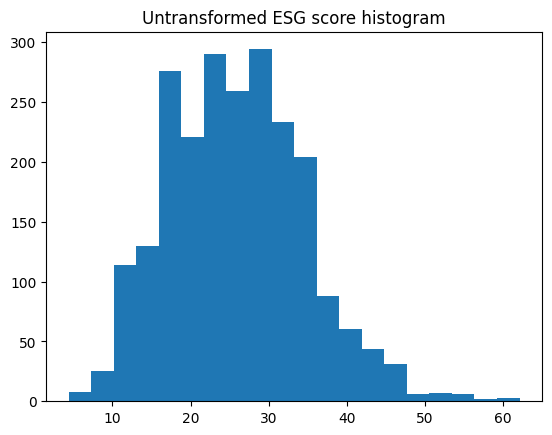

In [523]:
plt.hist(merged_kaggle_yahoo["total ESG score"], bins = 20)
plt.title('Untransformed ESG score histogram')

Text(0.5, 1.0, 'Transformed ESG score histogram')

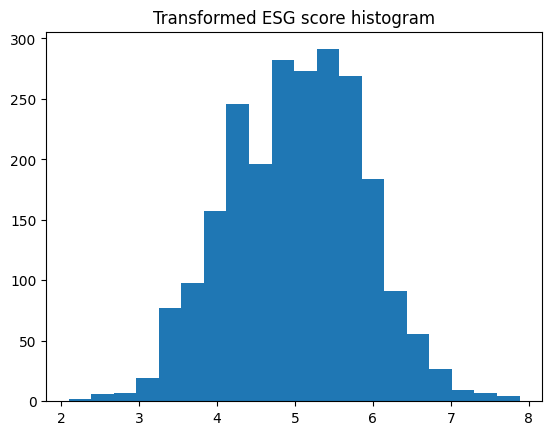

In [524]:
plt.hist(np.sqrt(merged_kaggle_yahoo["total ESG score"]), bins = 20) 
plt.title('Transformed ESG score histogram')

### Looking at the distribution of E, S and G components

We don't really go into the details of these breakdowns in the model, but a chart to visualize what it looks like (all somewhat right-skewed).

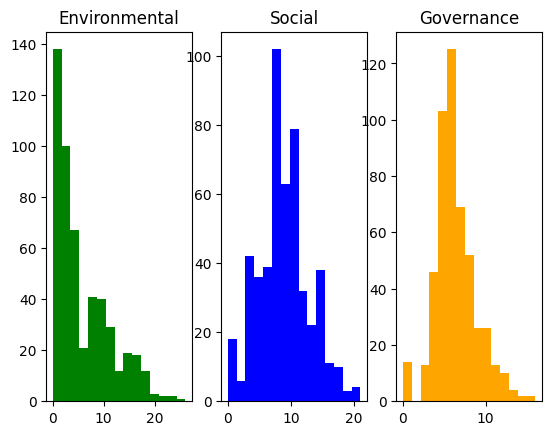

In [354]:
fig = plt.figure()
fig.add_subplot(131)   
plt.title("Environmental")
plt.hist(merged_kaggle_yahoo["e_score"], bins = 15, color = "green", label = "E") # pretty right skewed, should i
fig.add_subplot(132)   
plt.title("Social")
plt.hist(merged_kaggle_yahoo["s_score"], bins = 15, color = "blue") # looks normal
fig.add_subplot(133)   
plt.hist(merged_kaggle_yahoo["g_score"], bins = 15, color = "orange") # looks fairly normal i guess
plt.title("Governance")
plt.show()

### Looking at the distribution of controversy scores

Controversy scores, which reflect how much negative attention a company has gotten in the media about controversies that could relate to ESG, looked pretty standard — most of them are 2 or 3, and there are only 4 values, so we will only come back to this if we want a controversy-specific breakdown. 

Text(0.5, 1.0, 'Controversy score frequency table')

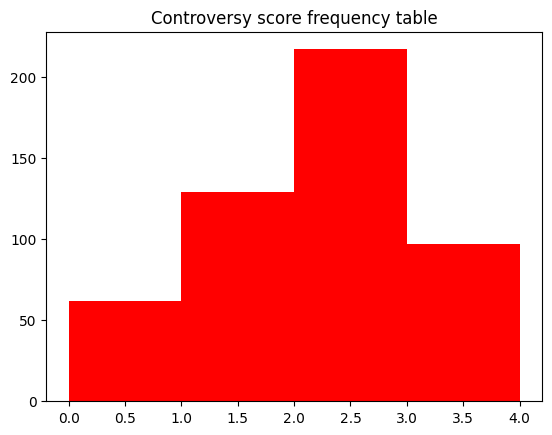

In [355]:
plt.hist(merged_kaggle_yahoo["controversy"], bins = 4, color = "red")
plt.title("Controversy score frequency table")

## B. The predictor variables: What are they? 

In [356]:
list(merged_kaggle_yahoo.columns)

['end',
 'filed',
 'form',
 'Name',
 'Ticker',
 'CIK',
 'Currency',
 'PriceVar5',
 'PriceVar10',
 'PriceVar20',
 'PriceVar30',
 'PriceVar60',
 'Assets',
 'CashAndCashEquivalentsAtCarryingValue',
 'CommonStockParOrStatedValuePerShare',
 'CommonStockSharesAuthorized',
 'CommonStockSharesIssued',
 'CommonStockSharesOutstanding',
 'CommonStockValue',
 'DeferredTaxAssetsOperatingLossCarryforwards',
 'DeferredTaxAssetsValuationAllowance',
 'EarningsPerShareBasic',
 'EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate',
 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
 'IncomeTaxExpenseBenefit',
 'Liabilities',
 'LiabilitiesAndStockholdersEquity',
 'NetCashProvidedByUsedInFinancingActivities',
 'NetCashProvidedByUsedInInvestingActivities',
 'NetCashProvidedByUsedInOperatingActivities',
 'NetIncomeLoss',
 'OperatingIncomeLoss',
 'PreferredStockSharesAuthorized',
 'RetainedEarningsAccumulatedDeficit',
 'ShareBasedCompensation',
 'St

There's a lot going on that we would like to narrow down, and an easy way to do that is by removing columns that are mostly NAs. We remove the columns that have more than 50 NAs (1/10 of the dataset, approximately): 

In [357]:
# get na counts for each column 
na_counts = pd.DataFrame(merged_kaggle_yahoo.isna().sum())
na_counts.columns = ["na_count"]
na_counts = na_counts.sort_values(by=["na_count"], ascending=False)

# see which columns have more than 100 NAs 
problem_columns = list(na_counts[na_counts["na_count"] > 100].index)
print(problem_columns)

# drop those columns (the print statement works if the cells are run in the correct order)
merged_kaggle_yahoo = merged_kaggle_yahoo.drop(problem_columns, axis=1)

['DeferredTaxAssetsOperatingLossCarryforwards', 'Depreciation', 'AccountsReceivableNetCurrent', 'PreferredStockSharesAuthorized', 'CommonStockSharesOutstanding', 'Liabilities', 'PaymentsToAcquirePropertyPlantAndEquipment', 'EffectiveIncomeTaxRateReconciliationAtFederalStatutoryIncomeTaxRate', 'InterestExpense', 'EffectiveIncomeTaxRateContinuingOperations', 'AccountsPayableCurrent', 'PropertyPlantAndEquipmentGross', 'DeferredTaxAssetsNet', 'OperatingLeaseLiabilityCurrent', 'DeferredTaxAssetsGross', 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest', 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment', 'DeferredIncomeTaxLiabilities', 'CommonStockParOrStatedValuePerShare', 'CurrentIncomeTaxExpenseBenefit', 'OperatingLeaseLiabilityNoncurrent']


Now, we have 65 columns left instead of 80. Of particular note are columns mentioned when introducing this dataset that, based on research, could be related pretty strongly to ESG metrics without being explicitly tied to them. All columns are listed below, but of particular interest are:
* Stock price data like price variance
* Metrics that predict company size like Assets and Liabilities
* Goodwill
* Measures related to tax benefits

In [360]:
print(np.shape(merged_kaggle_yahoo))
# Printing the columns
print(list(merged_kaggle_yahoo.columns))

(506, 65)
['end', 'filed', 'form', 'Name', 'Ticker', 'CIK', 'Currency', 'PriceVar5', 'PriceVar10', 'PriceVar20', 'PriceVar30', 'PriceVar60', 'Assets', 'CashAndCashEquivalentsAtCarryingValue', 'CommonStockSharesAuthorized', 'CommonStockSharesIssued', 'CommonStockValue', 'DeferredTaxAssetsValuationAllowance', 'EarningsPerShareBasic', 'IncomeTaxExpenseBenefit', 'LiabilitiesAndStockholdersEquity', 'NetCashProvidedByUsedInFinancingActivities', 'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInOperatingActivities', 'NetIncomeLoss', 'OperatingIncomeLoss', 'RetainedEarningsAccumulatedDeficit', 'ShareBasedCompensation', 'StockholdersEquity', 'AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'AssetsCurrent', 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents', 'ComprehensiveIncomeNetOfTax', 'CurrentFederalTaxExpenseBenefit', 'CurrentStateAndLocalTaxExpenseBenefit', 'DeferredFederalIncomeTaxExpenseBenefit', 'DeferredIncomeTaxExpenseBenefit', 'EarningsPerShareDilut

### Correlation plot/matrix to see which variables might be good predictors of ESG score

Heatmap for of all variables, where lighter = more highly correlated. Some observations:
* Most notably, the **price variance** variable sare quite highly correlated with each other but not with many other variables in the model, so I use one of them in my model because it seems independently important
* The lease-related and net cash-related variables are also highly correlated with each other 
* Assets is correlated with lots of things (which makes sense), so including assets in my model would encompass a lot of the variables that involve cash and property
* Unrecognized tax benefits also correlate with lots of things
* This plot doesn't show everything, though, so we can print actual values and zoom in on certain sections to make sure these observations hold

<AxesSubplot: >

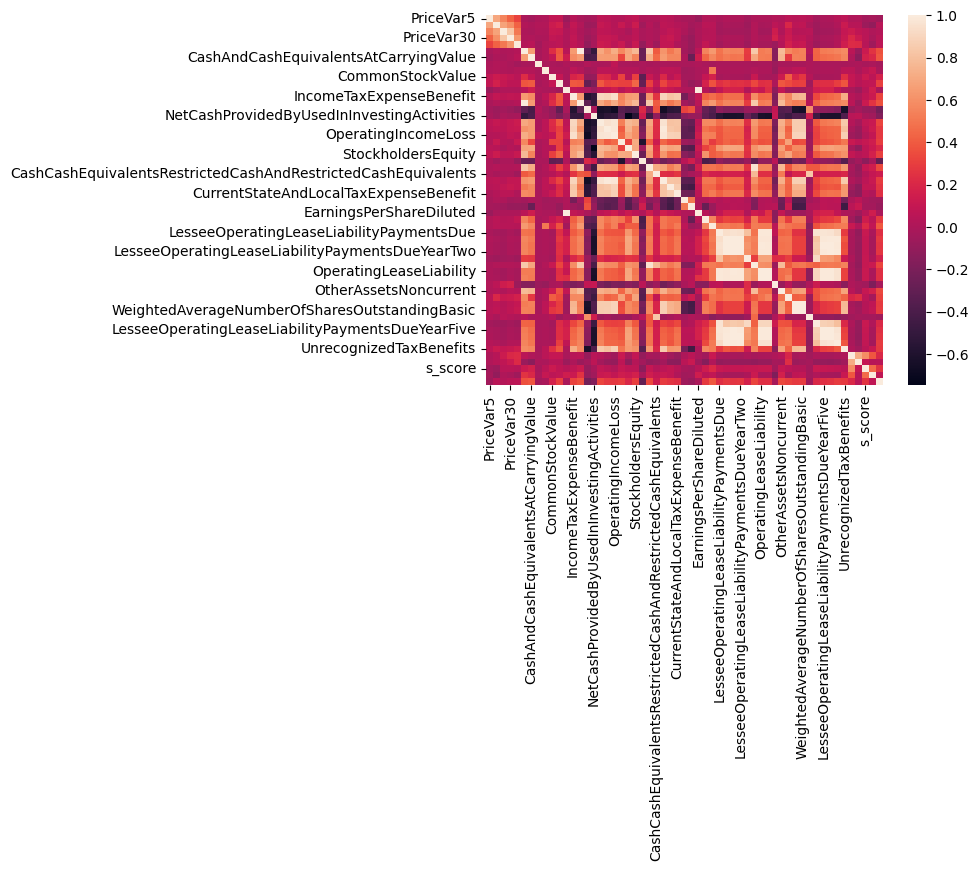

In [615]:
# Renaming a variable to something shorter so the chart looks better
merged_kaggle_yahoo = merged_kaggle_yahoo.rename(columns={"CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect": "CashCashEquivalentsIncludingExchangeRate"})

corr = merged_kaggle_yahoo.corr()
sns.heatmap(corr) # xticklabels=True, yticklabels=True) # uncomment to see all labels

# print(corr) # uncomment to display values


### Example of zooming in on correlation between price variance vars

Collinearity between the pricevars (all are at least 0.4), so we will just use one of them. I went through similar reasoning for other variables to decide what to use:

<AxesSubplot: >

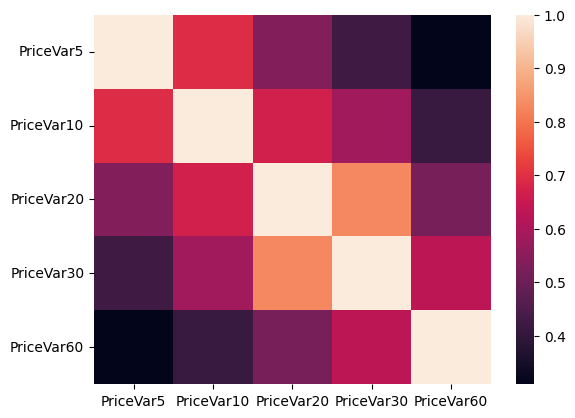

In [368]:
corr2 = merged_kaggle_yahoo.iloc[:,[7,8,9,10,11]].corr()
sns.heatmap(corr2)

### Correlations with predictor variable (ESG score)

Most variables don't predict the variance in ESG score super well on their own, but we likely need to transform and combine them. From this chart, though, price variance, assets and tax/equity numbers seem promising.

In [369]:
pd.DataFrame(np.abs(corr["total ESG score"])).sort_values(by=["total ESG score"], ascending=False)

,total ESG score
total ESG score,1.000000
e_score,0.711075
s_score,0.586396
g_score,0.390157
PriceVar60,0.227683
controversy,0.212325
PriceVar30,0.198209
PropertyPlantAndEquipmentNet,0.196006
InterestPaidNet,0.127573
RetainedEarningsAccumulatedDeficit,0.122795


## C. Distributions of predictor variables and looking at/transforming promising ones

This section contains lots of scatter plots of predictor variables vs. response variable, trying to see which might be promising for our model and how to transform them.

### Assets

For assets, a log transformation seems to make the predictors a bit more normal.

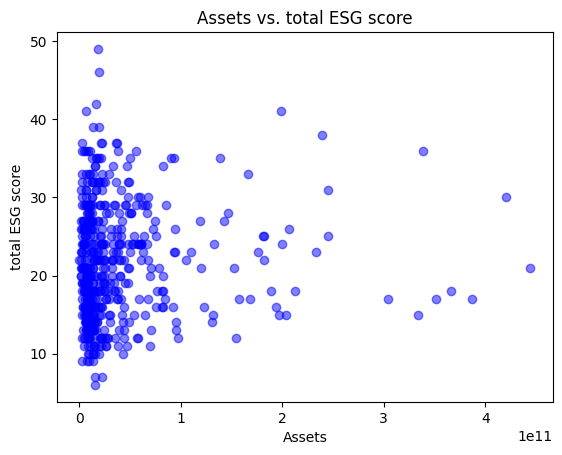

In [370]:
plt.scatter(merged_kaggle_yahoo["Assets"], merged_kaggle_yahoo["total ESG score"], c="blue", alpha=0.5)
plt.title("Assets vs. total ESG score")
plt.xlabel("Assets")
plt.ylabel("total ESG score")
plt.show()

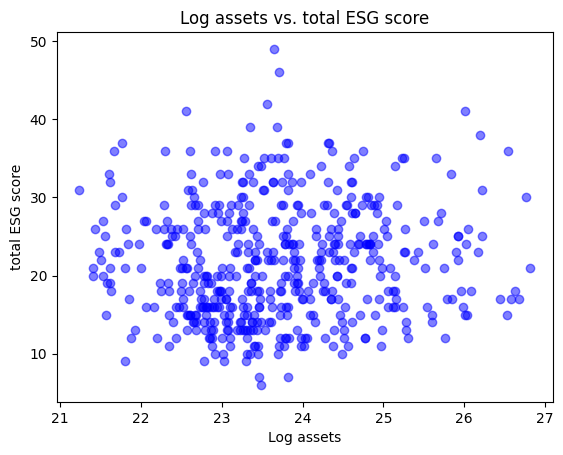

In [371]:
# Removing an outlier # Don't run this code after running other cells
np.log(merged_kaggle_yahoo["Assets"]).sort_values(ascending=True)[:10] # maybe remove this one ? 
merged_kaggle_yahoo = merged_kaggle_yahoo.drop(labels=32, axis=0)

plt.scatter(np.log(merged_kaggle_yahoo["Assets"]), merged_kaggle_yahoo["total ESG score"], c="blue", alpha=0.5)
plt.title("Log assets vs. total ESG score")
plt.xlabel("Log assets")
plt.ylabel("total ESG score")
plt.show()

The above graph looks much better — keeping a note to include log assets in the model.

### Price variance

Of all the price variance variables, the 60-day variance was the most strongly correlated with total ESG score, so let's use that. It looks fine — no obvious transformations stick out to me

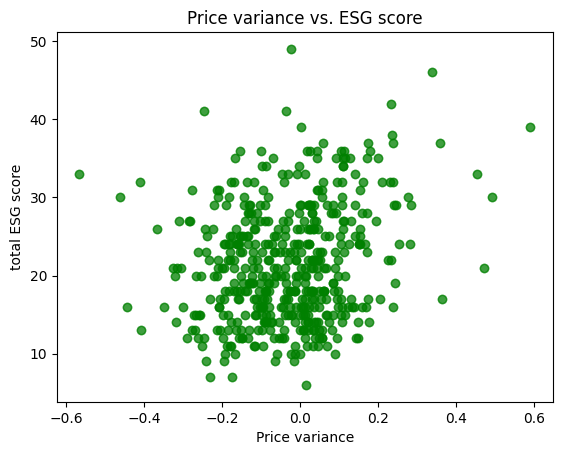

In [380]:
plt.scatter(merged_kaggle_yahoo["PriceVar60"], merged_kaggle_yahoo["total ESG score"], c="green", alpha=0.5)
# plt.show()

# remove outliers??
merged_kaggle_yahoo["PriceVar60"].sort_values(ascending=False)[:10]
# remove the last two, original index 178
# merged_kaggle_yahoo = merged_kaggle_yahoo.drop(labels=178, axis=0) # uncomment this line if running for the first time

# regraph
plt.scatter(merged_kaggle_yahoo["PriceVar60"], merged_kaggle_yahoo["total ESG score"], c="green", alpha=0.5)
plt.title("Price variance vs. ESG score")
plt.xlabel("Price variance")
plt.ylabel("total ESG score")
plt.show()

### Common stock value

I was curious about this one because I had read papers asserting that ESG metrics biased towards larger companies, which tended to have higher common stock prices. 

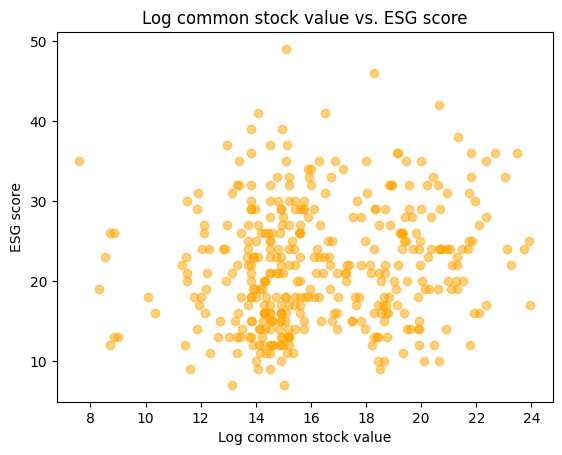

In [377]:
# common stock value
# plt.scatter(merged_kaggle_yahoo["CommonStockValue"], merged_kaggle_yahoo["total ESG score"], c="orange", alpha=0.5)
# plt.show()

# This needs a log transformation 
# plt.scatter(np.log(merged_kaggle_yahoo["CommonStockValue"]+1), merged_kaggle_yahoo["total ESG score"], c="orange", alpha=0.5)
# plt.show() 

# It's better but there are several zero values that throw off the data, and there are so many NA values that I
# merged_kaggle_yahoo["CommonStockValue"].sort_values(ascending=True)[:20]

# What would it look like without the zeroes — 19 of them are zeros 
# merged_kaggle_yahoo["CommonStockValue"].sort_values(ascending=True)[:20]
merged_without_zeroes = merged_kaggle_yahoo[merged_kaggle_yahoo["CommonStockValue"]!=0]
plt.scatter(np.log(merged_without_zeroes["CommonStockValue"]), merged_without_zeroes["total ESG score"], c="orange", alpha=0.5)
plt.title("Log common stock value vs. ESG score")
plt.xlabel("Log common stock value")
plt.ylabel("ESG score")
plt.show()

merged_kaggle_yahoo = merged_without_zeroes

### Goodwill

Even though it wasn't explicitly correlated with ESG score in the big matrix, research/reading makes me feel like it would still be a factor — taking a look at how the variable is distributed for possible inclusion:

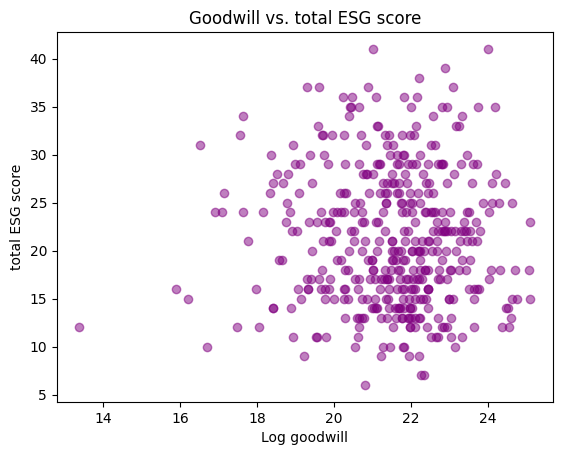

In [392]:
# remove outliers
# merged_kaggle_yahoo = merged_kaggle_yahoo.drop(labels=28, axis=0)

plt.scatter(np.log(merged_kaggle_yahoo["Goodwill"]+1), merged_kaggle_yahoo["total ESG score"], c="purple", alpha=0.5)
plt.title("Goodwill vs. total ESG score")
plt.xlabel("Log goodwill")
plt.ylabel("total ESG score")
plt.show()

## D. What companies have high/low ESG scores, anyways?

### Highest

It makes sense that a lot of these are energy companies — we'll prove this later.

In [396]:
merged_kaggle_yahoo.sort_values(by=["total ESG score"], ascending=False)[:10].iloc[:,[3,59]] # ["Name", "Ticker","total ESG score"]

,Name,total ESG score
79,"CONTINENTAL RESOURCES, INC.",49
478,COTERRA ENERGY INC.,46
246,Marathon Oil Corporation,42
451,GENERAL ELECTRIC COMPANY,41
35,RPM INTERNATIONAL INC/DE/,41
371,TransDigm Group Incorporated,39
199,ANTERO RESOURCES CORPORATION,39
499,Chevron Corp,38
177,PIONEER NATURAL RESOURCES CO,37
77,Mosaic Co,37


### Lowest 

Several of these are smaller electronics companies/software companies, which makes sense as well.

In [400]:
merged_kaggle_yahoo.sort_values(by=["total ESG score"], ascending=False)[474:].iloc[:,[3,59]] # ["Name", "Ticker","total ESG score"]

,Name,total ESG score
158,ARROW ELECTRONICS INC,10
324,ELECTRONIC ARTS INC.,10
166,Accenture plc,10
285,"KEYSIGHT TECHNOLOGIES,Â INC.",9
14,CDW CORP,9
364,ROBERT HALF INTERNATIONAL INC.,9
388,"Hasbro, Inc.",9
265,"CBRE GROUP, INC.",7
195,Jones Lang LaSalle Incorporated,7
440,FLEX LTD.,6


# III. Building a model

Based on all of the analysis in part II of this notebook, I'm proposing that we include these variables:
- total ESG score (outcome variable)
- PriceVar60 (removed an outlier)
- Assets (log)
- CommonStockValue (removed the zeroes +  log)
- Goodwill (log)
- CurrentStateAndLocalTaxExpenseBenefit


## A. Model A — Plain and Small

This model is ... fine. The biggest problem I have with is its small dataset, due to the large number of NAs and lack of standardization of the financial data we're using. We will attempt to address that in Model B (where I hand-augmented the ESG data), but given what we have, we have something pretty significant:
* Large R-squared, both raw and adjusted, of > **0.9**
* A large F-statistic (and conversely small corresponding probability)
* Common stock value isn't a super significant predictor, so we will remove that for the next iteration of the model
* PriceVar and Assets are the only significant predictors (if we use a threshold of >+/-2 t-value) — we will play around with removing variables in the next iteration of the model

In [616]:
lr_dataset = pd.concat([merged_kaggle_yahoo["PriceVar60"],
                  np.log(merged_kaggle_yahoo["Assets"]+1),
                  np.log(merged_kaggle_yahoo["CommonStockValue"]+1),
                  np.log(merged_kaggle_yahoo["Goodwill"]+1),
                  np.log(merged_kaggle_yahoo["IncomeTaxExpenseBenefit"]+1), 
                   np.sqrt(merged_kaggle_yahoo["total ESG score"])], axis=1)

print(np.shape(lr_dataset))
lr_dataset = lr_dataset.dropna() # make note of what dropna does to my sample size 
print(np.shape(lr_dataset)) # it decreases it pretty significantly -- we will address this in Model B
x = lr_dataset.iloc[:, :5]
y = lr_dataset["total ESG score"]

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

(484, 6)
(303, 6)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              2218.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                   2.37e-233
Time:                        00:00:52   Log-Likelihood:                         -343.77
No. Observations:                 303   AIC:                                      697.5
Df Residuals:                     298   BIC:                                      716.1
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## B. Model B: More data?

Let's look with a larger dataset (that I hand-augmented from the Sustainalytics website), with 2357 datapoints with ESG scores rather than 506. This dataset overlaps — and is thus an augmentation — of the original, in that the ESG scores for the original 506 datapoints are the same in this dataset.

(2357, 2)
  ticker  total ESG score
0    TSQ             20.5
1    NOG             62.1
2   ROCC             62.0
3    MUX             59.8
4   ESTE             57.8


Text(0.5, 1.0, 'Histogram of total ESG score in bigger dataset')

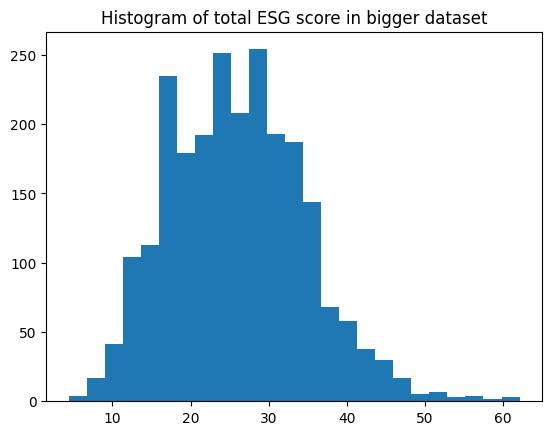

In [617]:
sustainalytics_data = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/yahoo_sustainalytics.csv")
sustainalytics_data = sustainalytics_data.iloc[:,:2]
sustainalytics_data = sustainalytics_data.dropna() # 2357, which is a lot more than the 5000
print(np.shape(sustainalytics_data))
print(sustainalytics_data[:5])
plt.hist(sustainalytics_data["total ESG score"], bins = 25)
plt.title("Histogram of total ESG score in bigger dataset")

### Corrplot for the new data

This correlation plot shows the correlations between variables that all correlate relatively highly (the top 20) with ESG score. This makes it increasingly clear that:
* No one variable explains a large amount of ESG score variation
* Assets and liabilites are very closely correlated
* So are the two tax expense benefit variables, but they don't seem very correlated with other variables, so it might be good to include one — probably the one that correlates more highly with ESG score, CurrentStateAndLocalTaxExpenseBenefit
* Interestingly, I don't see any negative correlations on this plot

(2355, 81)


<AxesSubplot: >

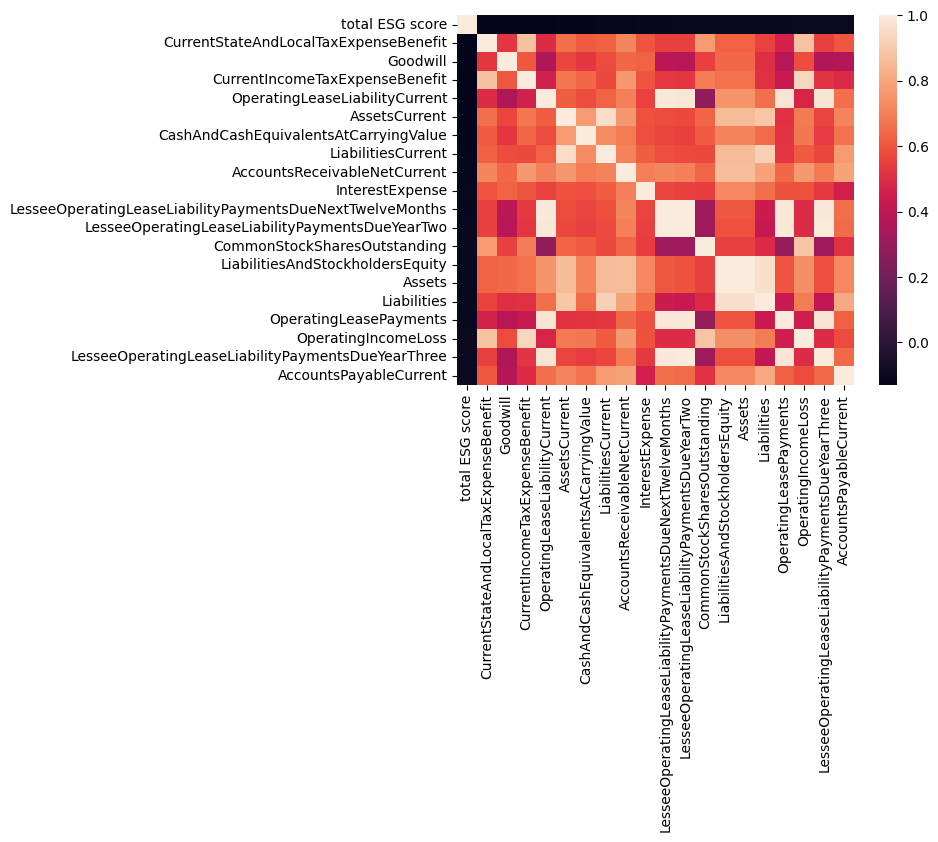

In [618]:
# rename ticker variable to be the same 
sustainalytics_data = sustainalytics_data.rename(columns={"ticker": "Ticker"})
sdata_bigger = pd.merge(sustainalytics_data, final_10k_set, on='Ticker')
print(np.shape(sdata_bigger))

corr2 = sdata_bigger.corr()
highest_corr = pd.DataFrame(np.abs(corr2["total ESG score"])).sort_values(by=["total ESG score"], ascending=False)[:20]

# taking the columns with the highest corr with total ESG score and seeing a corrplot with that
corr_highest = sdata_bigger.iloc[:,sdata_bigger.columns.get_indexer(highest_corr.T.columns)].corr()
sns.heatmap(corr_highest)

This plot shows us what variables correlate most strongly with total ESG score:

In [619]:
print(pd.DataFrame(np.abs(corr2["total ESG score"])).sort_values(by=["total ESG score"], ascending=False)[:20])

                                                    total ESG score
total ESG score                                            1.000000
CurrentStateAndLocalTaxExpenseBenefit                      0.130131
Goodwill                                                   0.123212
CurrentIncomeTaxExpenseBenefit                             0.123154
OperatingLeaseLiabilityCurrent                             0.121842
AssetsCurrent                                              0.119869
CashAndCashEquivalentsAtCarryingValue                      0.117380
LiabilitiesCurrent                                         0.114048
AccountsReceivableNetCurrent                               0.113083
InterestExpense                                            0.111278
LesseeOperatingLeaseLiabilityPaymentsDueNextTwe...         0.110081
LesseeOperatingLeaseLiabilityPaymentsDueYearTwo            0.107967
CommonStockSharesOutstanding                               0.107388
LiabilitiesAndStockholdersEquity                

### Checking on CurrentStateAndLocalTaxExpenseBenefit since we didn't use it before

After transforming and removing zeroes, it seems like a weak negative correlation:

/Users/phoebeliu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


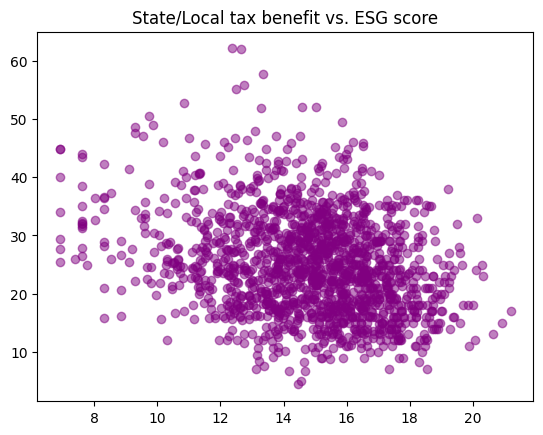

In [620]:
# plt.scatter(np.log(sdata_bigger["CurrentStateAndLocalTaxExpenseBenefit"]+1), sdata_bigger["total ESG score"], c="purple", alpha=0.5)
sdata_bigger_no_zeroes = sdata_bigger[sdata_bigger["CurrentStateAndLocalTaxExpenseBenefit"]!=0]
sdata_bigger = sdata_bigger_no_zeroes
plt.scatter(np.log(sdata_bigger["CurrentStateAndLocalTaxExpenseBenefit"]+1), sdata_bigger["total ESG score"], c="purple", alpha=0.5)
plt.title("State/Local tax benefit vs. ESG score")
plt.show()


In [621]:
sdata_bigger.columns.get_loc("IncomeTaxExpenseBenefit")
# 12, 13, 46, 53, 25
test_corr = sdata_bigger.iloc[:,[12, 13, 25, 46, 53]].corr()
print(test_corr)
# sns.heatmap(corr_highest)

                                       PriceVar60    Assets  \
PriceVar60                               1.000000  0.071484   
Assets                                   0.071484  1.000000   
IncomeTaxExpenseBenefit                  0.064509  0.679134   
CurrentStateAndLocalTaxExpenseBenefit    0.039852  0.627784   
Goodwill                                 0.073283  0.640014   

                                       IncomeTaxExpenseBenefit  \
PriceVar60                                            0.064509   
Assets                                                0.679134   
IncomeTaxExpenseBenefit                               1.000000   
CurrentStateAndLocalTaxExpenseBenefit                 0.861039   
Goodwill                                              0.484947   

                                       CurrentStateAndLocalTaxExpenseBenefit  \
PriceVar60                                                          0.039852   
Assets                                                          

### The model itself

The tax expense benefit barely improved the model in terms of R-squared but greatly lowered AIC/BIC and increased the significance of the predictors that were already in the model. I also removed variables that were collinear with others and variables that became insignificant once I took those out, leaving just assets and goodwill. The model's predictor significance is also improved from Model A — there's more data (1706 instead of around 300 rows), and the trends are similar. Every predictor has a p-value of < 0.05.

* Neither variable has a particularly large coefficient, but significance is high
* The other three variables — state/local tax expense benefit, goodwill and income tax benefit — all have a negative association with ESG score, which means a lower tax expense benefit and less "goodwill" would correlate with a higher ESG score (more impact ... which is surprising to me)

In [563]:
lr_dataset_2 = pd.concat([#sdata_bigger["PriceVar60"],
                  np.log(sdata_bigger["Assets"]+1),
                # np.log(sdata_bigger["CommonStockValue"]+1),
                 # np.log(sdata_bigger["CurrentStateAndLocalTaxExpenseBenefit"]+1),
                  np.log(sdata_bigger["Goodwill"]+1),
                 # np.log(sdata_bigger["IncomeTaxExpenseBenefit"]+1), 
                   np.sqrt(sdata_bigger["total ESG score"])], axis=1)

lr_dataset_2 = lr_dataset_2.dropna()
print(np.shape(lr_dataset_2)) # 1134 x 6 which is better ???? 
x2 = lr_dataset_2.iloc[:, :2]
y2 = lr_dataset_2["total ESG score"]
# x2 = sm.add_constant(x2)
reg2 = LinearRegression().fit(x2, y2)

# maybe do this with the statsmodels API one instead
print(reg2.score(x2, y2))
print(reg2.coef_)
print(reg2.intercept_)

print(np.shape(x2))
model = sm.OLS(y2, x2)
results2 = model.fit()
print(results2.summary())

(1706, 3)
0.046312655149338466
[-0.04754721 -0.0404308 ]
6.721906112259703
(1706, 2)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          2.246e+04
Date:                Thu, 15 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:28:09   Log-Likelihood:                         -2333.1
No. Observations:                1706   AIC:                                      4670.
Df Residuals:                    1704   BIC:                                      4681.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err   

## D. Model D — Adding industry data

I'm guessing that industry will be a pretty big predictor, since ESG risks vary widely by industry, and when I looked at the companies wth the highest ESG scores, most of them were energy (i.e. oil or gas) companies. This additional data comes from a Yahoo Finance web scrape that I linked in another notebook in the GitHub repo — getting data from Yahoo Finance's company profile page.

The variables that I use for this data are **industry** and **number of employees.**

There aren't a lot of data points that I could scrape (only 640, and it gets even smaller when merging it), but it's still insightful for our model-building purposes, trying to understand what non-ESG factors correlate with ESG scores (especially those that claim to control for variability across industry materiality and company size).

In [479]:
yahoo_profile_data = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/yahoo_company_profile.csv")
yahoo_profile_data[:10]
np.shape(yahoo_profile_data) 

(640, 5)

In [480]:
yahoo_profile_data = yahoo_profile_data.rename(columns={"ticker": "Ticker"})
sdata_yahoo = pd.merge(yahoo_profile_data, sustainalytics_data, on='Ticker')
print(np.shape(sdata_yahoo)) # dataset is very small

sdata_yahoo[:10]

(306, 6)


,Ticker,sector,industry,employees,description,total ESG score
0,ONCR,Healthcare,Biotechnology,82,"Oncorus, Inc., a clinical-stage biopharmaceuti...",26.3
1,LHCG,Healthcare,Medical Care Facilities,"29,000","LHC Group, Inc., a health care provider, speci...",21.2
2,WIRE,Industrials,Electrical Equipment & Parts,"1,440",Encore Wire Corporation manufactures and sells...,31.9
3,CAH,Healthcare,Medical Distribution,"45,570","Cardinal Health, Inc. operates as an integrate...",12.0
4,PGR,Financial Services,Insurance—Property & Casualty,"49,077","The Progressive Corporation, an insurance hold...",21.0
5,HOPE,Financial Services,Banks—Regional,"1,539","Hope Bancorp, Inc. operates as the bank holdin...",29.1
6,UNFI,Consumer Defensive,Food Distribution,"30,300","United Natural Foods, Inc., together with its ...",16.4
7,MDLZ,Consumer Defensive,Confectioners,"79,000","Mondelez International, Inc., through its subs...",24.0
8,SKT,Real Estate,REIT—Retail,310,"Tanger Factory Outlet Centers, Inc. (NYSE: SKT...",20.6
9,TPC,Industrials,Engineering & Construction,"7,800","Tutor Perini Corporation, a construction compa...",43.2


### Taking a look at employee and industry variables

There seems to a be a noticeable negative correlation between employee number (or its log, rather) and higher ESG impact. (Raw corr is about .24)

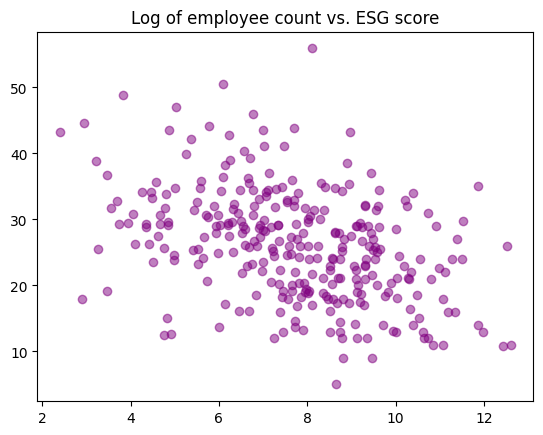

In [481]:
sdata_yahoo["employees"] = sdata_yahoo["employees"].replace(',','', regex=True)
sdata_yahoo["employees"] = sdata_yahoo["employees"].astype(float)

plt.scatter(np.log(sdata_yahoo["employees"]+1), sdata_yahoo["total ESG score"], c="purple", alpha=0.5)
plt.title("Log of employee count vs. ESG score")
plt.show()

In [46]:
corr3 = sdata_yahoo.corr()
pd.DataFrame(np.abs(corr3["total ESG score"])).sort_values(by=["total ESG score"], ascending=False)

,total ESG score
total ESG score,1.000000
employees,0.245004


### Averages by industry

Distribution of companies in each industry in this dataset:

In [500]:
sector_counts = sdata_yahoo['sector'].value_counts()
print(sector_counts)

Healthcare                63
Industrials               52
Financial Services        41
Technology                41
Consumer Cyclical         32
Real Estate               22
Energy                    15
Basic Materials           12
Consumer Defensive        10
Communication Services    10
Utilities                  8
Name: sector, dtype: int64


And a table showing the mean ESG score of a company in each industry, which confirms our earlier observation that energy/manufacturing companies have the highest ESG scores and tech companies are on the lower end of those scores.

In [622]:
sector_esg_df = sdata_yahoo.iloc[:,[1, 5]] 
by_industry = sector_esg_df.groupby(['sector']).mean().apply(list).sort_values(ascending=False, by="total ESG score")
print(by_industry)

# bar plot in case you want to look at it
# test_dict = sector_esg_df.groupby(['sector']).mean().apply(list).to_dict()
# sector_esg_dict = test_dict["total ESG score"]
#plt.bar(sector_esg_dict.keys(), sector_esg_dict.values(), color ='maroon',
    # width = 0.4)
# plt.show()

                        total ESG score
sector                                 
Energy                        36.766667
Basic Materials               31.100000
Utilities                     29.600000
Healthcare                    29.374603
Industrials                   27.801923
Financial Services            27.273171
Communication Services        25.680000
Consumer Defensive            25.050000
Consumer Cyclical             21.109375
Technology                    20.414634
Real Estate                   17.122727


## Model E: With industry data

Again, this model is insightful but limitedly so because the dataset is small (just under 300 rows). Despite the model's small dataset, it's our best one yet: Similar R-squared, low AIC and BIC< all variables are extremely significant, and ... yeah, in an ideal world, we'd merge this dataset with the data in our previous models, but the itnersection is too small to be meaningful. It also does not fit the assumptions of a linear model.

In [623]:
lr_dataset_3 = pd.concat([np.log(sdata_yahoo["employees"]+1),
                  sdata_yahoo["sector"], 
                       #   sdata_yahoo["industry"],
                          np.sqrt(sdata_yahoo["total ESG score"])], 
                          axis=1)

print(np.shape(lr_dataset_3))
lr_dataset_3 = lr_dataset_3.dropna()
print(np.shape(lr_dataset_3)) # dropna goes from 306 to 298 lol 
x3 = lr_dataset_3.iloc[:, :2]
# one hot encoding for categorical data - "basic materials" is the dummmy variable, which seems ok
x3_cat = pd.get_dummies(data=x3, drop_first=True)
y3 = lr_dataset_3["total ESG score"]
reg3 = LinearRegression().fit(x3_cat, y3)

model = sm.OLS(y3, x3_cat)
results = model.fit()
print(results.summary())

(306, 3)
(298, 3)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              453.1
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                   3.40e-174
Time:                        00:05:02   Log-Likelihood:                         -475.56
No. Observations:                 298   AIC:                                      973.1
Df Residuals:                     287   BIC:                                      1014.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----

### This isn't a lot of industry data though .. let's look at more

This data is from the TRBC Sector Classification that S&P market intelligence puts out. This data is not, however, publicly available, adding to the point that most ESG data is not transparent or accessible. I downloaded the data through the WRDS (Wharton Research Data Services) website. 

The following code block gets and cleans the industry data:

In [520]:
sp_industry = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/SandP_WithIndustry.csv")
np.shape(sp_industry) # 1921 rows by 15 columns
# print(sp_industry.columns) # these are the columns, but we're mostly just interested in "simpleindustry" and "ticker"
industry_data = sp_industry.iloc[:, [9, 14]]
print(np.shape(industry_data)) # 1921 which is a lot more than 600

# print(industry_data["simpleindustry"].value_counts()[:10]) # there are 64 industries here
# print(industry_data["simpleindustry"].value_counts()[50:])
# collect everything that's below 5 into one thing 
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Distributors", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Gas Utilities", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Tobacco", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Containers and Packaging", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Automobiles", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Multiline Retail", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Water Utilities", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Paper and Forest Products", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Water Utilities", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Airlines", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Marine", "Other")
industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Transportation Infrastructure", "Other")

# final value counts
print(industry_data["simpleindustry"].value_counts())


(1921, 2)
Banks                                               218
Biotechnology                                       129
Specialty Retail                                     86
Software                                             83
Machinery                                            72
Health Care Equipment and Supplies                   71
Health Care Providers and Services                   56
Hotels, Restaurants and Leisure                      53
Equity Real Estate Investment Trusts (REITs)         49
Electronic Equipment, Instruments and Components     48
Food Products                                        46
Household Durables                                   46
Media                                                40
Capital Markets                                      40
Insurance                                            40
Pharmaceuticals                                      39
Thrifts and Mortgage Finance                         39
Diversified Consumer Services         

/var/folders/6g/vcm0h1717p1dxtz94m2gvtf80000gn/T/ipykernel_949/197193027.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Distributors", "Other")
/var/folders/6g/vcm0h1717p1dxtz94m2gvtf80000gn/T/ipykernel_949/197193027.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_data["simpleindustry"] = industry_data["simpleindustry"].str.replace("Gas Utilities", "Other")
/var/folders/6g/vcm0h1717p1dxtz94m2gvtf80000gn/T/ipyk

In [508]:
# merge it and drop duplicates
industry_data = industry_data.rename(columns={"ticker": "Ticker"})
merged_with_industry = pd.merge(industry_data, sdata_bigger, on='Ticker') 
merged_with_industry = merged_with_industry.drop_duplicates()
merged_with_industry[:10]

,Ticker,simpleindustry,total ESG score,end,filed,form,Name,CIK,Currency,PriceVar5,...,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect,EffectiveIncomeTaxRateContinuingOperations,LesseeOperatingLeaseLiabilityPaymentsDueAfterYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFive,LesseeOperatingLeaseLiabilityPaymentsDueYearFour,OperatingLeasePayments,UnrecognizedTaxBenefits,DeferredIncomeTaxLiabilities
0,BOKF,Banks,23.0,2021-12-31,2022-02-23,10-K,BOK FINANCIAL CORP,CIK0000875357,USD,-0.029227,...,68594322.0,68591920.0,1.656837e+09,0.226,130000000.0,22600000.0,23600000.0,25300000.0,21092000.0,170899000.0
3,AROW,Banks,32.0,2021-12-31,2022-03-11,10-K,ARROW FINANCIAL CORPORATION,CIK0000717538,USD,-0.001176,...,16073000.0,16018000.0,7.670500e+07,0.226,NaN,NaN,NaN,794000.0,0.0,19449000.0
4,CATY,Banks,31.5,2021-12-31,2022-03-01,10-K,Cathay General Bancorp,CIK0000861842,USD,-0.043871,...,78570638.0,78268369.0,1.028626e+09,0.219,3248000.0,2639000.0,3431000.0,9900000.0,NaN,21328000.0
5,CBU,Banks,28.9,2021-12-31,2022-03-01,10-K,"COMMUNITY BANK SYSTEM, INC.",CIK0000723188,USD,-0.001268,...,54400000.0,53977000.0,NaN,0.214,5846000.0,3062000.0,4401000.0,8203000.0,0.0,89593000.0
8,CHCO,Banks,30.9,2021-12-31,2022-02-24,10-K,CITY HOLDING COMPANY,CIK0000726854,USD,0.038271,...,30463000.0,30407000.0,1.059720e+08,0.208,NaN,NaN,NaN,NaN,1846000.0,15551000.0
9,CPF,Banks,22.9,2021-12-31,2022-02-23,10-K,Central Pacific Financial Corp.,CIK0000701347,USD,-0.041120,...,28257323.0,28003744.0,2.248400e+08,NaN,NaN,NaN,NaN,6533000.0,NaN,16958000.0
10,CVBF,Banks,29.7,2021-12-31,2022-03-01,10-K,CVB FINANCIAL CORP.,CIK0000354647,USD,0.007857,...,135382000.0,135165000.0,NaN,0.286,1438000.0,2101000.0,3112000.0,7081000.0,0.0,28737000.0
11,FBNC,Banks,34.5,2021-12-31,2022-03-01,10-K,FIRST BANCORP,CIK0000811589,USD,-0.029847,...,30027785.0,29876151.0,9.387200e+07,NaN,22499000.0,1685000.0,1707000.0,1814000.0,NaN,19411000.0
12,FFBC,Banks,30.7,2021-12-31,2022-02-18,10-K,FIRST FINANCIAL BANCORP.,CIK0000708955,USD,-0.012229,...,95897385.0,95034690.0,-1.102300e+07,NaN,50311000.0,6269000.0,6673000.0,6860000.0,2386000.0,93010000.0
13,FLIC,Banks,29.4,2021-12-31,2022-03-11,10-K,THE FIRST OF LONG ISLAND CORPORATION,CIK0000740663,USD,-0.021583,...,23762983.0,23655635.0,NaN,0.192,2239000.0,1503000.0,1793000.0,2475000.0,0.0,11820000.0


## F. Model F: Bringing everything together (industry + other financial metrics)

I think the model would be even better if I could include employee count, but I couldn't find that information easily for enough companies for it to be insightful.

Here's a table that shows a similar trend from this new S&P market intelligence ESG metric — namely, that oil/gas companies have the highest ESG impact scores: 

In [575]:
simpleindustry_esgscore = merged_with_industry.iloc[:,[1, 2]]
simpleindustry_esgscore.groupby(['simpleindustry']).mean().sort_values(by="total ESG score", ascending=False) 

,total ESG score
simpleindustry,
"Oil, Gas and Consumable Fuels",47.525000
Chemicals,37.085714
Construction Materials,37.000000
Food Products,34.664706
Construction and Engineering,34.346667
Beverages,33.400000
Pharmaceuticals,32.927778
Metals and Mining,32.600000
Personal Products,32.200000


### Let's see if we can get a better model combining industry with the other stuff:

Brought together insights from the previous 5 models to create this one — this seems like our best one yet (by all the similar metrics from the last ones). Interestingly, goodwill and price variance became less significant when adding industry (they may be correlated in some way), while assets became more significant. I ended up removing goodwill, which actually made the model better.

In [624]:
lr_dataset_4 = pd.concat([# merged_with_industry["PriceVar60"],
                  np.log(merged_with_industry["Assets"]+1),
                 #  np.log(merged_with_industry["CommonStockValue"]+1), # not significant here
                  # np.log(merged_with_industry["Goodwill"]+1),
                 # np.log(merged_with_industry["CurrentStateAndLocalTaxExpenseBenefit"]+1), 
                   merged_with_industry["simpleindustry"],
                   np.sqrt(merged_with_industry["total ESG score"])], axis=1)


print(np.shape(lr_dataset_4))
lr_dataset_4 = lr_dataset_4.dropna()
print(np.shape(lr_dataset_4)) # 621 x 6, which is still not huge but better than 298
x4 = lr_dataset_4.iloc[:, :2]
x4_cat = pd.get_dummies(data=x4, drop_first=True)
y4 = lr_dataset_4["total ESG score"]

model = sm.OLS(y4, x4_cat)
results4 = model.fit()
print(results4.summary())

(999, 3)
(999, 3)
                                 OLS Regression Results                                
Dep. Variable:        total ESG score   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                              904.2
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        00:05:39   Log-Likelihood:                         -1054.8
No. Observations:                 999   AIC:                                      2218.
Df Residuals:                     945   BIC:                                      2483.
Df Model:                          54                                                  
Covariance Type:            nonrobust                                                  
                                                                      coef    std err          t      

# III. Trying the model with another ESG rating dataset 

I downloaded ESG scores from Refinitiv through WRDS, and the first few lines are displayed below:

In [513]:
refinitiv_data = pd.read_csv("/Users/phoebeliu/Documents/SDS_Senior_Project/WDRS_Data_Query_All.csv")
print(np.shape(refinitiv_data)) # this has multiple years though
refinitiv_data[:5]

# take fiscal year 2021 for these 

# for the purposess of this project we are only interested in score and cscore -- cscore takes into account 
# controversies -- we will use regular score, but it doesn't make a big difference in the model

(7780, 18)


,OrgID,FisYear,Score,CScore,ControversiesScore,ResourceUseScore,EmissionsScore,InnovationScore,WorkforceScore,HumanRightsScore,CommunityScore,ProductRespScore,ManagementScore,ShareholdersScore,CSRStrategyScore,OrgName,PrimExchg,tick
0,10295,2019,0.677259,0.677259,1.0,0.722477,0.845041,0.0,0.784644,0.551948,0.983146,0.973568,0.770983,0.396882,0.903974,Imperial Oil Ltd,TOR,IMO
1,10295,2021,0.630801,0.630801,1.0,0.598814,0.808244,0.0,0.602990,0.490099,0.971761,0.970260,0.806352,0.431352,0.897183,Imperial Oil Ltd,TOR,IMO
2,10295,2017,0.628874,0.628874,1.0,0.687500,0.881395,0.0,0.635827,0.467290,0.879921,0.951613,0.732595,0.460443,0.781659,Imperial Oil Ltd,TOR,IMO
3,10295,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Imperial Oil Ltd,TOR,IMO
4,10295,2020,0.642132,0.642132,1.0,0.626033,0.832075,0.0,0.608014,0.465789,0.970383,0.970703,0.870798,0.404412,0.882090,Imperial Oil Ltd,TOR,IMO


### Histogram of Refinitiv scores

Text(0.5, 1.0, 'Transformed ESG score histogram')

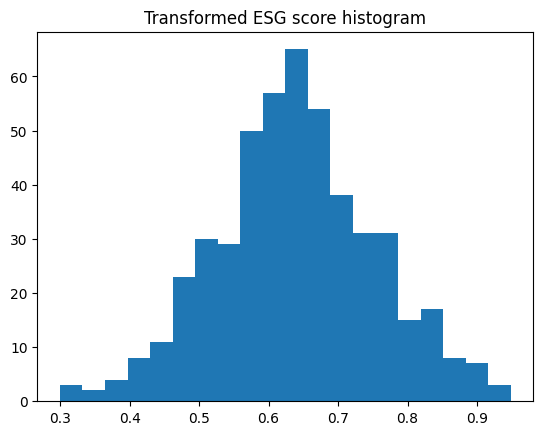

In [625]:
refinitiv_data = refinitiv_data.rename(columns={"tick": "Ticker"})
refinitiv_merge = pd.merge(refinitiv_data, merged_with_industry, on='Ticker')
refinitiv_merge = refinitiv_merge[refinitiv_merge["FisYear"]==2021]
refinitiv_merge[:10]



plt.hist(np.sqrt(refinitiv_merge["Score"]), bins = 20) 
plt.title('Transformed ESG score histogram')

In [626]:
refinitiv_merge.sort_values(by="Score", ascending=True)[:50].iloc[:,[15, 2]]

,OrgName,Score
641,Napco Security Technologies Inc,0.089756
2818,Corsair Gaming Inc,0.101577
1630,Willis Lease Finance Corporation,0.106988
1594,Carriage Services Inc.,0.122298
729,P.A.M. Transportation Services Inc.,0.132166
800,Rollins Inc.,0.142923
2576,Karuna Therapeutics Inc,0.145389
203,Coca-Cola Consolidated Inc,0.149471
2626,Ladder Capital Corp,0.154085
978,Valhi Inc.,0.164819


## Testing the model

This one is pretty insightful, since nonpublic and expensive Refinitiv data was more robust — 1685 datapoints, which is pretty good — and didn't make a huge difference in how well the model predicted the ESG score. This is evidence towards ESG scores being correlated to some non-ESG company metrics, namely:
* Industry
* Assets (a proxy for company size) and employee size
* Price variance
* Goodwill (which is arguably an "ESG" metric and very sugjective)
* Tax expense benefit

Several ended up being correlated with each other or otherwise insignificicant, so I removed variables until we got to just assets and goodwill, like our previous model that worked fairly well.

In [627]:
lr_dataset_5 = pd.concat([#refinitiv_merge["PriceVar60"],
                  np.log(refinitiv_merge["Assets"]+1),
               #   np.log(merged_with_industry["CommonStockValue"]+1), # not significant here
                 np.log(refinitiv_merge["Goodwill"]+1),
               # np.log(refinitiv_merge["CurrentStateAndLocalTaxExpenseBenefit"]+1), 
                 #  refinitiv_merge["simpleindustry"],
        np.sqrt(refinitiv_merge["Score"])], axis=1) # check to make sure this is actually a valid thing to be doing


print(np.shape(lr_dataset_5))
lr_dataset_5 = lr_dataset_5.dropna()
print(np.shape(lr_dataset_5)) # 
x5 = lr_dataset_5.iloc[:, :2]
x5_cat = pd.get_dummies(data=x5, drop_first=True)
y5 = lr_dataset_5["Score"]

model = sm.OLS(y5, x5_cat)
results5 = model.fit()
print(results5.summary())

(487, 3)
(395, 3)
                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              7727.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                   3.19e-316
Time:                        00:06:49   Log-Likelihood:                          335.36
No. Observations:                 395   AIC:                                     -666.7
Df Residuals:                     393   BIC:                                     -658.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------